<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/File_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import packages and modules

In [1]:
%%capture
!pip install -qq pytorch_tabnet
!pip install optuna
!pip install --upgrade catboost
!pip install optuna-integration-pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
#!pip install keras-tuner --upgrade
#!pip install keras-nlp
#!pip install BorutaShap
#!pip install scikit-learn==1.2.2
#!pip install scikit-lego
!pip install skops

In [2]:
import pandas as pd
import numpy as np

from termcolor import colored
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import os
from joblib import dump, load
import pandas as pd
import numpy as np
from scipy.stats import iqr, skew, kurtosis, mode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark", {"grid.color": ".1", "grid.linestyle": ":", "axes.facecolor": ".9"})

from warnings import filterwarnings
from termcolor import colored
from warnings import filterwarnings; filterwarnings(action = 'ignore');
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss, \
                            mean_squared_error, mean_absolute_error, r2_score, \
                            make_scorer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, \
                                  OrdinalEncoder, OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.base import clone

from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, RepeatedStratifiedKFold, \
                                    cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import k_means
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, mutual_info_classif, mutual_info_regression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingClassifier, StackingClassifier, VotingRegressor, StackingRegressor, \
                             RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, \
                             HistGradientBoostingClassifier, HistGradientBoostingRegressor \

from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import optuna
from optuna.samplers import TPESampler

import matplotlib as mpl

In [3]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 768x576 with 0 Axes>

In [4]:
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Define Configuration and Data classes
In the code below we load the data and display some basic information about the dataset such as: the number of missing entries, the features types, and the number of unique categories per categorical feature.

In [5]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=15, shuffle=True, random_state=SEED)
    VERSION = '2'

class Data:
    path       = False
    or_path    = ''
    to_drop    = False
    target     = 'Price'

    def __init__(self):
        self.train      = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_enc_ext.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/X_enc_ext.csv",index_col=0)
        self.test       = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/test_enc_ext.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/test_enc_ext.csv",index_col=0)
        self.submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
        self.original   = pd.read_csv(self.or_path) if self.or_path else pd.DataFrame()

    @property
    def X(self):
        return self.train.drop(columns=self.target)
    @property
    def y(self):
        return self.train[[self.target]]
    @property
    def X_test(self):
        return self.test
    @property
    def X_original(self):
        if len(self.original) != 0:
            return self.original.drop(columns=self.target)
        return pd.DataFrame()
    @property
    def y_original(self):
        if len(self.original) != 0:
            return self.original[[self.target]]
        return pd.DataFrame()
    @property
    def cat_features(self):
        return self.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
    @property
    def num_features(self):
        return self.X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def submit(self, sub: np.ndarray, desc: str):
        '''Submit the predictions in the adequate format'''
        self.submission[self.target] = sub
        self.submission.to_csv(f'SUB_{CFG.VERSION}_{desc}.csv', index=False)
        print(colored('Submission has been made.', color='green', attrs=['bold', 'dark']))

    @staticmethod
    def sep_line():
        print(colored(f'{"_____"*14}', color='black'))
        print('')
    @staticmethod
    def head(head_text):
        print(colored(f'{"    "} ➩ {head_text} ', color='green', attrs=['dark']))

    def display_data(self):
        self.head(f'𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: {self.train.shape} | {self.test.shape}')
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝')
        display(self.train.head(5))
        self.head('𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝')
        display(self.test.head(5))
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨')
        display(self.train.info())
        self.head('𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨')
        display(self.test.info())
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.train.describe().T)
        self.head('𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.test.describe().T)
        self.sep_line()

        def nunique_null(train, test):
            nunique_train, nunique_test = {}, {}
            nulls_train, nulls_test = {}, {}

            for col in test.columns:
                nunique_train[col], nunique_test[col] = train[col].nunique(), test[col].nunique()
                nulls_train[col], nulls_test[col] = train[col].isna().sum(), test[col].isna().sum()

            df = pd.DataFrame([nunique_train, nunique_test,
                               nulls_train, nulls_test],
                              index=['Train nunique', 'Test nunique',
                                     'Train null', 'Test null'])
            return df

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬')
        display(nunique_null(self.train, self.test))
        self.sep_line()

        self.head('𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬')
        display(f'Train duplicated: {self.train.duplicated().sum()}')
        display(f'Test duplicated: {self.test.duplicated().sum()}')
        if self.train.duplicated().sum() > 0:
            self.train = self.train.drop_duplicates()
            print('Train duplicates dropped.')
        if self.test.duplicated().sum() > 0:
            #self.test = self.test.drop_duplicates()
            print('Test duplicates dropped.')
        self.sep_line()

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧')
        cat_cols = [c for c in self.test.columns if self.train[c].nunique() <= 40 or
                    c in self.test.select_dtypes(include=['object', 'category']).columns]

        def compare_unique_categories(train, test, cat_cols):
            unique_train_dic, unique_test_dic = {}, {}

            for c in cat_cols:
                unique_train_c = train[c].unique()
                unique_test_c = test[c].unique()

                count_tr = sum(1 for cat in unique_train_c if cat not in unique_test_c and not pd.isna(cat))
                count_te = sum(1 for cat in unique_test_c if (cat not in unique_train_c and not pd.isna(cat)))

                unique_train_dic[c] = count_tr
                unique_test_dic[c] = count_te

            result_df = pd.DataFrame([unique_train_dic, unique_test_dic],
                                     index=['in train not in test', 'in test not in train'])

            return result_df

        display(compare_unique_categories(self.train, self.test, cat_cols))

data = Data()
data.display_data()

     ➩ 𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: (3994318, 31) | (200000, 30) 
______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Capacity (kg)_missing,Mat_Siz_Col,Siz_Lap_Col,Bra_Siz_Wat,Siz_Lap_Wat,Mat_Lap_Wat,Bra_Siz_Sty,Bra_Lap_Wat,Siz_Com_Lap,Siz_Lap_Sty,Mat_Com_Lap,Mat_Siz_Com,Bra_Siz_Com,Com_Lap_Wat,Bra_Siz_Lap,Bra_Mat_Siz,Siz_Com_Wat,Siz_Com_Sty,TE_wc,skew_0,skew_1,Price
0,1,1,1,7,2,1,3,0,-0.917722,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.261445,-0.292388,-0.428820,112.15875
1,1,0,3,1,2,2,1,3,1.300573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.621130,-0.302957,-0.460902,68.88056
2,5,1,3,2,2,1,1,6,-0.196013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016408,-0.301780,-1.112454,39.17320
3,3,3,3,8,2,1,1,3,-0.727615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.498987,-0.301780,-0.551413,80.60793
4,0,0,1,0,2,2,1,3,-0.037447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016408,-0.375870,0.519525,86.02312


     ➩ 𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Capacity (kg)_missing,Mat_Siz_Col,Siz_Lap_Col,Bra_Siz_Wat,Siz_Lap_Wat,Mat_Lap_Wat,Bra_Siz_Sty,Bra_Lap_Wat,Siz_Com_Lap,Siz_Lap_Sty,Mat_Com_Lap,Mat_Siz_Com,Bra_Siz_Com,Com_Lap_Wat,Bra_Siz_Lap,Bra_Mat_Siz,Siz_Com_Wat,Siz_Com_Sty,TE_wc,skew_0,skew_1
0,4,1,3,2,1,1,3,3,0.381607,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.414531,0.195748,0.428915
1,3,0,1,7,1,2,0,3,-0.637706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.095293,0.000521,0.040421
2,0,0,0,9,1,2,1,1,-0.889313,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.164135,-0.061768,1.242390
3,0,3,0,0,2,1,1,3,0.066921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.516258,-0.295283,0.744158
4,2,3,0,2,2,2,3,0,-1.162081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016408,-0.426006,0.348637


______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3994317
Data columns (total 31 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Brand                         int64  
 1   Material                      int64  
 2   Size                          int64  
 3   Compartments                  int64  
 4   Laptop Compartment            int64  
 5   Waterproof                    int64  
 6   Style                         int64  
 7   Color                         int64  
 8   Weight Capacity (kg)          float64
 9   Weight Capacity (kg)_missing  int64  
 10  Mat_Siz_Col                   int64  
 11  Siz_Lap_Col                   int64  
 12  Bra_Siz_Wat                   int64  
 13  Siz_Lap_Wat                   int64  
 14  Mat_Lap_Wat                   int64  
 15  Bra_Siz_Sty                   int64  
 16  Bra_Lap_Wat           

None

     ➩ 𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Brand                         200000 non-null  int64  
 1   Material                      200000 non-null  int64  
 2   Size                          200000 non-null  int64  
 3   Compartments                  200000 non-null  int64  
 4   Laptop Compartment            200000 non-null  int64  
 5   Waterproof                    200000 non-null  int64  
 6   Style                         200000 non-null  int64  
 7   Color                         200000 non-null  int64  
 8   Weight Capacity (kg)          200000 non-null  float64
 9   Weight Capacity (kg)_missing  200000 non-null  int64  
 10  Mat_Siz_Col                   200000 non-null  int64  
 11  Siz_Lap_Col                   200000 non-null  int64  
 12  Bra_Siz_Wat                   2

None

______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Brand,3994318.0,2.584763e+00,1.843070,0.000000,1.000000,3.000000,4.000000,5.000000
Material,3994318.0,2.070342e+00,1.562931,0.000000,1.000000,3.000000,4.000000,4.000000
Size,3994318.0,1.314194e+00,1.222013,0.000000,0.000000,1.000000,3.000000,3.000000
Compartments,3994318.0,4.435745e+00,2.881279,0.000000,2.000000,4.000000,7.000000,9.000000
Laptop Compartment,3994318.0,1.469268e+00,0.546253,0.000000,1.000000,1.000000,2.000000,2.000000
Waterproof,3994318.0,1.469387e+00,0.544327,0.000000,1.000000,1.000000,2.000000,2.000000
Style,3994318.0,1.359897e+00,1.229806,0.000000,0.000000,1.000000,3.000000,3.000000
Color,3994318.0,2.898823e+00,2.082539,0.000000,1.000000,3.000000,5.000000,6.000000
Weight Capacity (kg),3994318.0,-4.876153e-09,1.000000,-1.865994,-0.851663,0.006300,0.856963,1.719577
Weight Capacity (kg)_missing,3994318.0,4.526430e-04,0.021271,0.000000,0.000000,0.000000,0.000000,1.000000


     ➩ 𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Brand,200000.0,2.583635,1.845064,0.000000,1.000000,3.000000,4.000000,5.000000
Material,200000.0,2.074010,1.560463,0.000000,1.000000,3.000000,4.000000,4.000000
Size,200000.0,1.315085,1.222397,0.000000,0.000000,1.000000,3.000000,3.000000
Compartments,200000.0,4.443590,2.879623,0.000000,2.000000,4.000000,7.000000,9.000000
Laptop Compartment,200000.0,1.468485,0.546469,0.000000,1.000000,1.000000,2.000000,2.000000
Waterproof,200000.0,1.468915,0.545110,0.000000,1.000000,1.000000,2.000000,2.000000
Style,200000.0,1.359800,1.230834,0.000000,0.000000,1.000000,3.000000,3.000000
Color,200000.0,2.901365,2.081725,0.000000,1.000000,3.000000,5.000000,6.000000
Weight Capacity (kg),200000.0,-0.002493,0.999763,-1.865994,-0.852032,0.006356,0.854115,1.719577
Weight Capacity (kg)_missing,200000.0,0.000385,0.019618,0.000000,0.000000,0.000000,0.000000,1.000000


______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight Capacity (kg)_missing,Mat_Siz_Col,Siz_Lap_Col,Bra_Siz_Wat,Siz_Lap_Wat,Mat_Lap_Wat,Bra_Siz_Sty,Bra_Lap_Wat,Siz_Com_Lap,Siz_Lap_Sty,Mat_Com_Lap,Mat_Siz_Com,Bra_Siz_Com,Com_Lap_Wat,Bra_Siz_Lap,Bra_Mat_Siz,Siz_Com_Wat,Siz_Com_Sty,TE_wc,skew_0,skew_1
Train nunique,6,5,4,10,3,3,4,7,907130,2,2,2,3,3,3,3,2,2,3,3,2,2,2,2,3,2,3,1811134,36,72
Test nunique,6,5,4,10,3,3,4,7,108681,2,2,2,3,3,3,3,2,2,3,3,2,2,2,2,3,2,3,78300,36,72
Train null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


______________________________________________________________________

     ➩ 𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬 


'Train duplicated: 0'

'Test duplicated: 1'

Test duplicates dropped.
______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)_missing,Mat_Siz_Col,Siz_Lap_Col,Bra_Siz_Wat,Siz_Lap_Wat,Mat_Lap_Wat,Bra_Siz_Sty,Bra_Lap_Wat,Siz_Com_Lap,Siz_Lap_Sty,Mat_Com_Lap,Mat_Siz_Com,Bra_Siz_Com,Com_Lap_Wat,Bra_Siz_Lap,Bra_Mat_Siz,Siz_Com_Wat,Siz_Com_Sty,skew_0
in train not in test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
in test not in train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
data.X.shape, data.y.shape, data.X_test.shape

((3994318, 30), (3994318, 1), (200000, 30))

In [7]:
print(data.cat_features)

['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)_missing', 'Mat_Siz_Col', 'Siz_Lap_Col', 'Bra_Siz_Wat', 'Siz_Lap_Wat', 'Mat_Lap_Wat', 'Bra_Siz_Sty', 'Bra_Lap_Wat', 'Siz_Com_Lap', 'Siz_Lap_Sty', 'Mat_Com_Lap', 'Mat_Siz_Com', 'Bra_Siz_Com', 'Com_Lap_Wat', 'Bra_Siz_Lap', 'Bra_Mat_Siz', 'Siz_Com_Wat', 'Siz_Com_Sty']


In [8]:
data.X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3994317
Data columns (total 30 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Brand                         int64  
 1   Material                      int64  
 2   Size                          int64  
 3   Compartments                  int64  
 4   Laptop Compartment            int64  
 5   Waterproof                    int64  
 6   Style                         int64  
 7   Color                         int64  
 8   Weight Capacity (kg)          float64
 9   Weight Capacity (kg)_missing  int64  
 10  Mat_Siz_Col                   int64  
 11  Siz_Lap_Col                   int64  
 12  Bra_Siz_Wat                   int64  
 13  Siz_Lap_Wat                   int64  
 14  Mat_Lap_Wat                   int64  
 15  Bra_Siz_Sty                   int64  
 16  Bra_Lap_Wat                   int64  
 17  Siz_Com_Lap                   int64  
 18  Siz_Lap_Sty                

# 3. Data Preprocessing
Here we define a preprocessing class to handle missing values and perform some feature engineering.

In [9]:
class Preprocessing:
    def __init__(self, data: Data):
        self.data = data

    def feature_preparation(self):
        ''' User-define feature engineering and preprocessing'''
        print('⇒ Train-Test-Original shapes before preprocessing:',
              self.data.train.shape, self.data.test.shape, self.data.original.shape)

        df = pd.concat([self.data.train, self.data.test, self.data.original], axis=0)
        ## -- Operations
        # Convert categoricals and handle missing
        df = self.convert_categorical(df)
        df = self.handle_nan(df)

        # Retrieve train, test and original
        self.data.train    = df[:len(self.data.train)].reset_index(drop=True)
        self.data.test     = df[len(self.data.train):len(self.data.train)+\
                                len(self.data.test)].reset_index(drop=True).drop(columns=data.target)
        self.data.original = df[len(self.data.train)+len(self.data.test):].reset_index(drop=True)
        print('⇒ Train-Test-Original shapes after preprocessing:', self.data.train.shape, self.data.test.shape, self.data.original.shape)
        print('⇒ Preprocessing finished')

    @staticmethod
    def convert_categorical(df):
        '''For converting data to categoricals'''
        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].astype(str).fillna('missing').astype('category')
        return df

    @staticmethod
    def handle_nan(df):
        for c in df.select_dtypes(exclude=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].median())

        for c in df.select_dtypes(include=['object', 'category', 'bool', 'int']).columns:
            df[c] = df[c].fillna(df[c].mode()[0])

        return df

    @staticmethod
    def calculate_fi():

        def sorted_fi(fi): # fi is a list of feature importances
            fi = list(zip(data.X.columns.to_list(), fi))
            return sorted(fi, key=lambda x: x[1], reverse=True)

        # Make a pipeline to transform X for those method which can't handle categorical and NaN natively
        pipe    = make_pipeline(SimpleImputer(strategy='most_frequent'), CountEncoder(), StandardScaler())
        X_FE    = pipe.fit_transform(data.X)

        FI_LGBM = sorted_fi(LGBMRegressor(verbose=-1, random_state=CFG.SEED).fit(data.X, data.y).feature_importances_)

        FI_CB   = sorted_fi(CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features).fit(data.X, data.y).get_feature_importance())

        FI_RF   = sorted_fi(RandomForestRegressor(n_estimators=100, random_state=CFG.SEED).fit(X_FE, data.y).feature_importances_)

        FI_MI   = sorted_fi(list(mutual_info_regression(X_FE, data.y)))

        FIS     = [FI_LGBM, FI_CB, FI_RF, FI_MI]
        titles  = ['LGBM FI', 'CB FI', 'RF FI', 'MI']

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 10))
        for i, FI in enumerate(FIS):
            # Convert the list of tuples to a DataFrame for easier plotting
            FI_df = pd.DataFrame(FI[:15], columns=['Feature', 'Importance'])
            sns.barplot(x='Importance', y='Feature', data=FI_df, ax=axes[i], palette='Blues_r')
            axes[i].set_title(titles[i])

        plt.tight_layout()
        plt.show()


data = Data()
pp   = Preprocessing(data)
pp.feature_preparation()
#pp.calculate_fi()

⇒ Train-Test-Original shapes before preprocessing: (3994318, 31) (200000, 30) (0, 0)
⇒ Train-Test-Original shapes after preprocessing: (3994318, 31) (200000, 30) (0, 31)
⇒ Preprocessing finished


In [10]:
data.cat_features

['Brand',
 'Material',
 'Size',
 'Compartments',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color',
 'Weight Capacity (kg)_missing',
 'Mat_Siz_Col',
 'Siz_Lap_Col',
 'Bra_Siz_Wat',
 'Siz_Lap_Wat',
 'Mat_Lap_Wat',
 'Bra_Siz_Sty',
 'Bra_Lap_Wat',
 'Siz_Com_Lap',
 'Siz_Lap_Sty',
 'Mat_Com_Lap',
 'Mat_Siz_Com',
 'Bra_Siz_Com',
 'Com_Lap_Wat',
 'Bra_Siz_Lap',
 'Bra_Mat_Siz',
 'Siz_Com_Wat',
 'Siz_Com_Sty']

In [11]:
data.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 30 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Brand                         category
 1   Material                      category
 2   Size                          category
 3   Compartments                  category
 4   Laptop Compartment            category
 5   Waterproof                    category
 6   Style                         category
 7   Color                         category
 8   Weight Capacity (kg)          float64 
 9   Weight Capacity (kg)_missing  category
 10  Mat_Siz_Col                   category
 11  Siz_Lap_Col                   category
 12  Bra_Siz_Wat                   category
 13  Siz_Lap_Wat                   category
 14  Mat_Lap_Wat                   category
 15  Bra_Siz_Sty                   category
 16  Bra_Lap_Wat                   category
 17  Siz_Com_Lap                   category
 18  Si

We can observe that there is no consensus among the different methods to the most important features. 'MI' entry, which stands for the calculation from Mutual Information method, seems quite reasonable: the Overall quality of the house is the most important feature, followed by the Neighborhood, which ultimately reflects its location.

# 4. Modeling
### 4.1 Stacking

In [12]:
class TrainModels:
    def __init__(self, X, y, X_test, X_original, y_original, models):
        self.models     = models
        self.X          = X
        self.y          = y
        self.X_original = X_original
        self.y_original = y_original
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

    @staticmethod
    def convert_cat(df_):
        '''
        A function to convert dtypes to categorical if the catboost with all categorical
        features is called
        '''
        df = df_.copy()
        for c in df.columns.to_list():
            df[c] = df[c].astype(str).astype('category')
        return df


    def fit_model(self, name, model_, train_flag):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        CB_CAT_FLAG = True if 'CB_CAT' in name.upper() else False

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E2/layers_3_staked_models')

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]

            # Adds the original data to training set only
            if self.X_original is not None:
                x_train = pd.concat([x_train, self.X_original], axis=0)
                y_train = pd.concat([y_train, self.y_original], axis=0)

            # -- Create a special block to convert all features to categorical
            if CB_CAT_FLAG:
                x_train = self.convert_cat(x_train)
                x_val   = self.convert_cat(x_val)

            model = clone(model_)

            if 'CB' in name.upper():
              if train_flag:
                model.fit(x_train,y_train,eval_set=[(x_val,y_val)], early_stopping_rounds=101)
                model.save_model(f"{name}_{fold}.bin")
              else:
                model = CatBoostRegressor()
                model.load_model(f"{name}_{fold}.bin")

            elif 'LGBMR' in name.upper():
              early_stop = early_stopping(stopping_rounds=101)
              if train_flag:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stop],categorical_feature=self.categorical_features)
                model.booster_.save_model(f'{name}_{fold}.txt')
              else:
                model = lgb.Booster(model_file=f'{name}_{fold}.txt')

            elif 'LGBMP' in name.upper():
              # Fit the model
              if train_flag:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}.pkl')
              else:
                model = load(f'{name}_{fold}.pkl')

            elif 'XGBR' in name.upper():
              if train_flag:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)
                model.save_model(f'{name}_{fold}.json')
              else:
                model = XGBRegressor()  # Create an instance of the model
                model.load_model(f'{name}_{fold}.json')

            elif 'LGBM_2' in name.upper():
              model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)


            elif 'HGB_' in name.upper():
              if train_flag:
                model.fit(x_train, y_train)
                dump(model, f'{name}_{fold}.pkl')
              else:
                model = load(f'{name}_{fold}.pkl')

            else:

              model.fit(x_train, y_train)

            y_pred_train = model.predict(x_train).ravel()
            y_pred_val   = model.predict(x_val).ravel()
            y_pred_test  = model.predict(self.X_test if not CB_CAT_FLAG else self.convert_cat(self.X_test)).ravel()

            oof_train[val_idx] = y_pred_val
            oof_test   += y_pred_test/CFG.CV.get_n_splits()

            train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))
            val_score   = np.sqrt(mean_squared_error(y_val, y_pred_val))

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    def fit_models(self):
        for name, model in list(self.models.items()):
            print(colored(f'{" "*4} Fitting {name}', color='red', attrs=['dark', 'bold']))
            self.fit_model(name, model[0], model[1])
            print("")

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

#### 4.1.1 First Level of Stacking
We define a bunch of tree-based methods with many different hyperparameters configurations to aggregate diversity.

In [13]:
os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2')

In [16]:
lgbm_params_4 = {'max_depth': 8, 'learning_rate': 0.02, 'n_estimators': 3000, 'num_leaves': 40}
lgbm_params_5 = {'max_depth': 5, 'learning_rate': 0.055, 'n_estimators': 3000, 'num_leaves': 31}
lgbm_params_6 = {'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 3000, 'num_leaves': 31}

cb_cat_params_4   = {'one_hot_max_size': 2, 'learning_rate': 0.055, 'grow_policy': 'Depthwise'}

models={
    'LGBMR1': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, boosting_type='GBDT', device='cpu',n_estimators=3000),True],
    'LGBMR2': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, boosting_type='dart', device='cpu',n_estimators=3000),True],
    'LGBMR3': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, data_sample_strategy='GOSS', device='cpu',n_estimators=3000),True],
    'LGBMP4': [make_pipeline(CatBoostEncoder(), LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_4, device='cpu')),True],
    'LGBMR5': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_5, device='cpu'),True],
    #'LGBMR6': [LGBMRegressor(verbose=-1, random_state=CFG.SEED, **lgbm_params_6, device='gpu',n_estimators=300),True],

    'CB1'   :[CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, loss_function='RMSE', task_type='GPU', iterations=3000),True],
    'CB2'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, grow_policy='Depthwise', loss_function='RMSE', task_type='GPU', iterations=3000),True],
    'CB3'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, grow_policy='Lossguide', loss_function='RMSE', task_type='GPU', iterations=3000),True],
    'CB4'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, **cb_cat_params_4, loss_function='RMSE', task_type='GPU', iterations=3000),True],
    'CB5'   : [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, iterations=3000, task_type='GPU'),True],
    'CB_CAT1': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), iterations=3000, task_type='GPU'),True],
    'CB_CAT2': [CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.test.columns.to_list(), iterations=3000, **cb_cat_params_4, loss_function='RMSE', task_type='GPU'),True],

    'XGBR1' : [XGBRegressor(random_state=CFG.SEED, enable_categorical=True, device='gpu', early_stopping_rounds=101, tree_method= 'gpu_hist',n_estimators=2000,verbosity=0),True],
    'XGBR2' : [XGBRegressor(random_state=CFG.SEED, enable_categorical=True, max_depth=4, learning_rate=0.04, device='gpu', early_stopping_rounds=101,tree_method= 'gpu_hist',n_estimators=2000),True],


    'HGB_TE': [make_pipeline(TargetEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
                                                                           learning_rate=0.035, max_depth=8,validation_fraction=0.15,
                                                                           early_stopping=True, l2_regularization=0.03,
                                                                            )),True],

    'HGB_CE': [make_pipeline(CountEncoder(), HistGradientBoostingRegressor(random_state=CFG.SEED, max_iter=5000,
                                                                            learning_rate=0.055, max_depth=5,
                                                                            early_stopping=True,  validation_fraction=0.15
                                                                          )),True],


}

TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

     Fitting LGBMR1
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1443]	valid_0's l2: 1494.15
Fold 1 → Training set Score: 38.40246 | Validation set Score: 38.65425
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[756]	valid_0's l2: 1495.71
Fold 2 → Training set Score: 38.52065 | Validation set Score: 38.67446
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1438]	valid_0's l2: 1492.64
Fold 3 → Training set Score: 38.40088 | Validation set Score: 38.63467
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1317]	valid_0's l2: 1494.49
Fold 4 → Training set Score: 38.41717 | Validation set Score: 38.65868
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2506]	valid_0's l2: 1494.61
Fold 5 → Training set Score: 38.22704 | Validation set Score: 38.66

KeyboardInterrupt: 

#### 4.1.2 Second Level of Stacking
We take the out-of-folds predictions from the previous models and fed them into simple linear methods like Ridge and Lasso. The alpha parameters have been tuned manually (i.e., trial and error).

In [ ]:
models2 = {
    'Ridge2': Ridge(alpha=1),
    'Lasso2': Lasso(alpha=0.0002),
    'LGBM_2' : LGBMRegressor(max_depth=2, random_state=CFG.SEED, verbose=-1, device='cpu'),
}

TM2 = TrainModels(X=TM.OOF_train, y=data.y, X_test=TM.OOF_test, X_original=None, y_original=None, models=models2)
TM2.fit_models()
data.submit(sub=TM2.OOF_test.mean(axis=1), desc='lasso_ridge_mean')

     Fitting Ridge2
Fold 1 → Training set Score: 38.64529 | Validation set Score: 38.65613
Fold 2 → Training set Score: 38.64462 | Validation set Score: 38.66528
Fold 3 → Training set Score: 38.64713 | Validation set Score: 38.63023
Fold 4 → Training set Score: 38.64542 | Validation set Score: 38.65410
Fold 5 → Training set Score: 38.64406 | Validation set Score: 38.67322
Fold 6 → Training set Score: 38.64875 | Validation set Score: 38.60754
Fold 7 → Training set Score: 38.64411 | Validation set Score: 38.67247
Fold 8 → Training set Score: 38.64905 | Validation set Score: 38.60347
Fold 9 → Training set Score: 38.64119 | Validation set Score: 38.71329
Fold 10 → Training set Score: 38.64514 | Validation set Score: 38.65823
Fold 11 → Training set Score: 38.64441 | Validation set Score: 38.66838
Fold 12 → Training set Score: 38.64614 | Validation set Score: 38.64404
Fold 13 → Training set Score: 38.65257 | Validation set Score: 38.55387
Fold 14 → Training set Score: 38.64617 | Validation s

#### 4.1.3 Third Level of Stacking
At this stage, the first level and second level out-of-fold predictions are incorporated into the original training data. This is then fed into another level of models to output the final stage of out-of-fold predictions which are finally averaged.

In [ ]:
train = pd.concat([data.X,      TM.OOF_train, TM2.OOF_train], axis=1)
test  = pd.concat([data.X_test, TM.OOF_test,  TM2.OOF_test], axis=1)

models3 = {
    'LGBM_3' : LGBMRegressor(verbose=-1, random_state=CFG.SEED, max_depth=4, device='cpu'),
    'CB_3'   : CatBoostRegressor(verbose=0, random_state=CFG.SEED, cat_features=data.cat_features, task_type='GPU'),
    'Ridge_3': make_pipeline(TargetEncoder(), Ridge(alpha=5)),
    'Lasso_3': make_pipeline(TargetEncoder(), Lasso(alpha=0.001)),
}

TM3  = TrainModels(X=train, y=data.y, X_test=test, X_original=None, y_original=None, models=models3)
TM3.fit_models()

TM3.save_predictions()

     Fitting LGBM_3
Fold 1 → Training set Score: 38.63058 | Validation set Score: 38.65215
Fold 2 → Training set Score: 38.62993 | Validation set Score: 38.66116
Fold 3 → Training set Score: 38.63235 | Validation set Score: 38.62540
Fold 4 → Training set Score: 38.63042 | Validation set Score: 38.65378
Fold 5 → Training set Score: 38.62958 | Validation set Score: 38.66855
Fold 6 → Training set Score: 38.63411 | Validation set Score: 38.60383
Fold 7 → Training set Score: 38.62951 | Validation set Score: 38.66775
Fold 8 → Training set Score: 38.63421 | Validation set Score: 38.60211
Fold 9 → Training set Score: 38.62673 | Validation set Score: 38.70965
Fold 10 → Training set Score: 38.63007 | Validation set Score: 38.65600
Fold 11 → Training set Score: 38.62995 | Validation set Score: 38.66410
Fold 12 → Training set Score: 38.63138 | Validation set Score: 38.64186
Fold 13 → Training set Score: 38.63791 | Validation set Score: 38.55275
Fold 14 → Training set Score: 38.63146 | Validation s

In [ ]:
data.submit(sub=TM3.OOF_test.mean(axis=1), desc='final_layer')

Submission has been made.


In [ ]:
TM3.OOF_test.mean(axis=1)

,0
0,81.828801
1,81.913722
2,88.117746
3,78.654571
4,80.203378
...,...
199995,83.698665
199996,79.667135
199997,83.700374
199998,82.015075


In [ ]:
TM3.save_predictions()

In [ ]:
TM3.OOF_test.mean(axis=1)
Data.submission

AttributeError: type object 'Data' has no attribute 'submission'

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E2/sample_submission.csv",index_col=0)
submission["Price"] = TM3.OOF_test.mean(axis=1).values
submission.to_csv("SUB_01_Final_Layer.csv")
final_layer_output = submission.copy()
display(submission.head())
submission["Price"] = TM2.OOF_test.mean(axis=1).values
submission.to_csv("SUB_01_Second_Layer.csv")
display(submission.head())
second_layer_output = submission.copy()

,Price
id,
300000,81.828801
300001,81.913722
300002,88.117746
300003,78.654571
300004,80.203378


,Price
id,
300000,81.825387
300001,82.018160
300002,88.450856
300003,78.714707
300004,80.377172


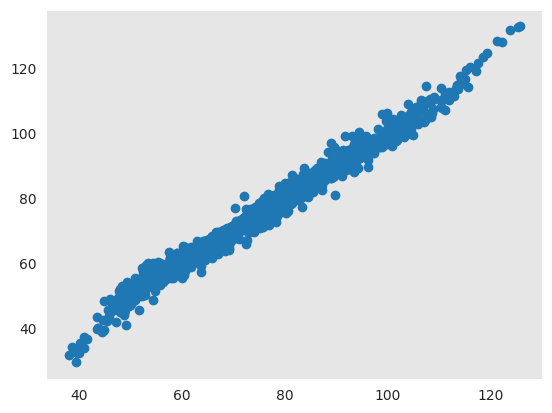

In [ ]:
plt.scatter(final_layer_output.values, second_layer_output.values)